In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import sys, argparse
%matplotlib inline

In [2]:
sns.set(style='white', context='paper', rc={'figure.figsize':(14,10)})

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = 'Classifier'
        self.image_size = 28
        self.image_channels = 1
        self.conv1 = nn.Conv2d(self.image_channels, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3136, 200)
        self.fc2 = nn.Linear(200, 10)
    
    def forward(self, x):
        self.batch_size = x.size(0)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(self.batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Class for convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=0, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)

        return x

# Class for de-convolution block
class DeConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=0, stride=1, padding=0, out_padding=0):
        super(DeConvBlock, self).__init__()
        self.conv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride, padding, out_padding, bias=False)
        self.norm = nn.BatchNorm2d(out_dim)
        self.relu = nn.ReLU(True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)

        return x

# Class for residual conv block
class ResidualConvBlock(nn.Module):
    def __init__(self, dim, kernel_size=0, stride=1, padding=0):
        super(ResidualConvBlock, self).__init__()
        self.pad1 = nn.ReplicationPad2d(padding)
        self.conv1 = nn.Conv2d(dim, dim, kernel_size, stride)
        self.norm1 = nn.InstanceNorm2d(dim)
        self.relu1 = nn.ReLU(True)
        self.pad2 = nn.ReplicationPad2d(padding)
        self.conv2 = nn.Conv2d(dim, dim, kernel_size, stride)
        self.norm2 = nn.InstanceNorm2d(dim)
        self.relu2 = nn.ReLU(True)
        self.module = nn.Sequential(self.pad1, self.conv1, self.norm1, self.relu1, self.pad2, self.conv2, self.norm2, self.relu2)
    
    def forward(self, x):
        return x + self.module(x)

# Main class for MAD-VAE
class MADVAE(nn.Module):
    def __init__(self):
        super(MADVAE, self).__init__()
        self.model_name = 'DAD-VAE'
        self.image_size = 28
        self.image_channels = 1
        self.h_dim = 4096
        self.z_dim = 128
        # module for encoder
        self.c1 = ConvBlock(self.image_channels, 64, 5, 1, 2)
        self.c2 = ConvBlock(64, 64, 4, 2, 3)
        self.c3 = ConvBlock(64, 128, 4, 2, 1)
        self.c4 = ConvBlock(128, 256, 4, 2, 1)
        self.e_module = nn.Sequential(self.c1, self.c2, self.c3, self.c4)
        self.mu =nn.Linear(self.h_dim, self.z_dim)
        self.sigma = nn.Linear(self.h_dim, self.z_dim)
        # module for image decoder
        self.linear = nn.Linear(self.z_dim, self.h_dim)
        self.d1 = DeConvBlock(256, 128, 4, 2, 1)
        self.d2 = DeConvBlock(128, 64, 4, 2, 1)
        self.d3 = DeConvBlock(64, 64, 4, 2, 3)
        self.d4 = nn.ConvTranspose2d(64, self.image_channels, 5, 1, 2, bias=False)
        self.img_module = nn.Sequential(self.d1, self.d2, self.d3, self.d4)

    # Encoder
    def encode(self, x):
        self.batch_size = x.size(0)
        x = self.e_module(x)
        x = x.view(self.batch_size, -1)
        mean = self.mu(x)
        var = self.sigma(x)
        distribution = Normal(mean, var)

        return distribution

    # Decoder for image denoising
    def img_decode(self, z):
        self.batch_size = z.size(0)
        x = F.relu(self.linear(z))
        x = x.view(self.batch_size, 256, 4, 4)

        return F.sigmoid(self.img_module(x))
    
    # Forward function
    def forward(self, x):
        dist = self.encode(x)
        if self.training == True:
            z = dist.rsample()
        else:
            z = dist.mean
        output = self.img_decode(z)
        
        return output, dist.mean, dist.stddev, z

In [4]:
# load classifier
classifier = Classifier()
classifier.load_state_dict(torch.load('../pretrained_model/classifier_mnist.pt'))
classifier.eval();

In [5]:
# load model
defense = MADVAE()
defense_pt = torch.load(f'../pretrained_model/combined/params.pt', map_location=torch.device('cpu'))
# for key in list(defense_pt.keys()):
    # defense_pt[key.replace('module.', '')] = defense_pt.pop(key)
defense.load_state_dict(defense_pt)
defense.eval();

In [10]:
# get data
attack = 'r-fgsm'
adv = np.load('../data/' + attack + '_xs_mnist.npy')
adv = adv.reshape(adv.shape[0],28*28)
sample = np.random.randint(adv.shape[0], size=3000)
adv = adv[sample,:]
adv_images = torch.from_numpy(adv.reshape(adv.shape[0], 1, 28, 28))

In [11]:
# perform defense
def_out, _, _, _ = defense(adv_images)
labels = classifier(def_out)
labels = torch.argmax(labels, 1).detach().numpy()

def_out = def_out.detach().numpy()
def_out = def_out.reshape(def_out.shape[0],28*28)

/Users/fred/.pyenv/versions/3.7.4/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


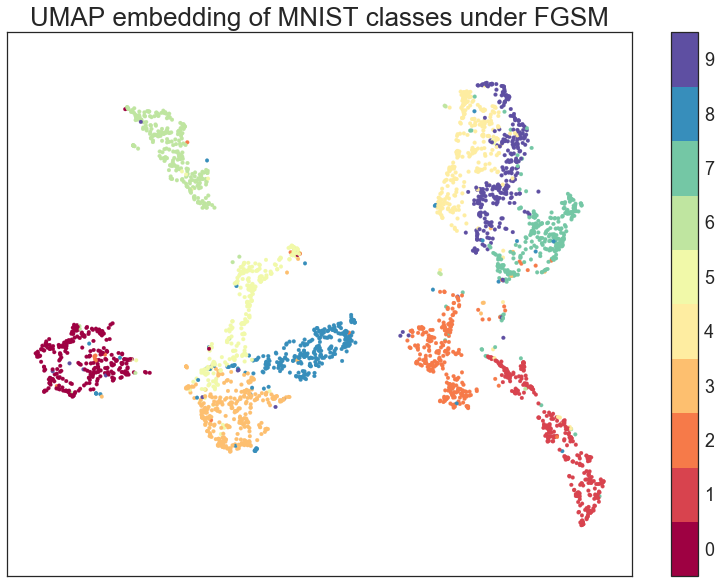

In [12]:
# fit using UMAP
fit = umap.UMAP(n_components=2, random_state=42)
u = fit.fit_transform(def_out.reshape(def_out.shape[0],28*28))

plt.scatter(u[:,0], u[:,1], c=labels, cmap='Spectral',s=14)
plt.gca().set_aspect('equal', 'datalim')
clb = plt.colorbar(boundaries=np.arange(11)-0.5)
clb.set_ticks(np.arange(10))
clb.ax.tick_params(labelsize=18)
plt.xticks([])
plt.yticks([])
plt.title('UMAP embedding of MNIST classes under FGSM', fontsize=26);